# MCMC tutorial publication results and plotting
Part of the Bayesian neural networks via MCMC: a Python-based tutorial

This notebook contains the code used to generate the results and plots for the paper.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import arviz as az
import glob, warnings
from ipywidgets import interact, fixed, widgets
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('/project')

from publication_results.models.mcmc import MCMC
from publication_results.convergence.convergence import gelman_rubin

## Load the results from the MCMC runs
Load in the results stored in the netcdf files.

In [3]:
models = ['linear','bnn','linear_thinning']# ['linear','bnn'] #['linear_tp','bnn_tp']
data = ['Sunspot', 'Abalone', 'Iris', 'Ionosphere']#
results_dir = os.path.join('publication_results','results')

results = {mm: {dd: None for dd in data} for mm in models}
for this_model in models:
    mod_results_dir = os.path.join(results_dir,'{}_model'.format(this_model))
    for this_data in data:
        # load all of the chains
        results_files = glob.glob(os.path.join(mod_results_dir,'mcmc_{}_*.nc'.format(this_data)))
        print('Found {} results files for {} model on {} data'.format(len(results_files),this_model,this_data))
        tmp_data = xr.open_mfdataset(results_files, combine='nested',concat_dim='chain')
        # re-ID the chains
        tmp_data.coords['chain'] = np.arange(len(results_files))
        results[this_model][this_data] = tmp_data

Found 5 results files for linear model on Sunspot data
Found 5 results files for linear model on Abalone data
Found 5 results files for linear model on Iris data
Found 5 results files for linear model on Ionosphere data
Found 5 results files for bnn model on Sunspot data
Found 5 results files for bnn model on Abalone data
Found 5 results files for bnn model on Iris data
Found 5 results files for bnn model on Ionosphere data
Found 5 results files for linear_thinning model on Sunspot data
Found 5 results files for linear_thinning model on Abalone data
Found 5 results files for linear_thinning model on Iris data
Found 5 results files for linear_thinning model on Ionosphere data


In [4]:
# load the data
x_train = {}
y_train = {}
x_test = {}
y_test = {}

for this_data in data:
    train_data   = np.loadtxt("data/{}/train.txt".format(this_data))
    test_data    = np.loadtxt("data/{}/test.txt".format(this_data))

    x_train[this_data] = train_data[:,:-1]
    y_train[this_data] = train_data[:,-1]
    x_test[this_data] = test_data[:,:-1]
    y_test[this_data] = test_data[:,-1]

# little lookup table
data_case = {'Sunspot':'regression','Abalone':'regression','Iris':'classification','Ionosphere':'classification'}

## Evaluate the model performance
Calculate the model performance metrics for the MCMC samples.

In [5]:
results_table = []# pd.DataFrame(columns=['train','test','model','data'])

for this_model in models:
    for this_data in data:
        # here we are collecting RMSE and accuracy for train and test
        train_dim = results[this_model][this_data].coords['train_idx'].shape[0]
        test_dim = results[this_model][this_data].coords['test_idx'].shape[0]
        train_pred = results[this_model][this_data].train_pred.values.reshape((-1,train_dim))
        test_pred = results[this_model][this_data].test_pred.values.reshape((-1,test_dim))

        # Print the train/test RMSE or accuracy in tabular format
        if data_case[this_data] == 'regression':
            # RMSE
            train_perf = np.array([MCMC.rmse(train_pred[_,:], y_train[this_data]) for _ in np.arange(train_pred.shape[0])])
            test_perf = np.array([MCMC.rmse(test_pred[_,:], y_test[this_data]) for _ in np.arange(test_pred.shape[0])])
            # # Store r2 of dy
            # train_perf = np.array([MCMC.r2(
            #     train_pred[_,1:].squeeze()-y_train[this_data][:-1],
            #     np.diff(y_train[this_data])
            # ) for _ in np.arange(train_pred.shape[0])])
            # test_perf = np.array([MCMC.r2(
            #     test_pred[_,1:].squeeze()-y_test[this_data][:-1],
            #     np.diff(y_test[this_data])
            # ) for _ in np.arange(test_pred.shape[0])])
        elif data_case[this_data] == 'classification':
            train_perf = np.array([MCMC.accuracy(train_pred[_,:], y_train[this_data]) for _ in np.arange(train_pred.shape[0])])
            test_perf = np.array([MCMC.accuracy(test_pred[_,:], y_test[this_data]) for _ in np.arange(test_pred.shape[0])])


        results_table.append(
            {
                'train_mean':train_perf.mean(),'test_mean':test_perf.mean(),
                'train_std':train_perf.std(),'test_std':test_perf.std(),
                'model':this_model,'data':this_data
            }
        )
results_table = pd.DataFrame(results_table)
display(results_table)

# return the latext to create this table with floats :.3f
print(results_table.to_latex(index=False,float_format=lambda x: '{:.3f}'.format(x)))

,train_mean,test_mean,train_std,test_std,model,data
0,0.025217,0.021724,0.013317,0.011669,linear,Sunspot
1,0.085271,0.085565,0.007065,0.006940,linear,Abalone
2,90.392038,90.844089,2.832002,3.038877,linear,Iris
3,89.059739,85.316038,1.335095,2.389743,linear,Ionosphere
4,0.026671,0.026011,0.004681,0.004635,bnn,Sunspot
5,0.079517,0.079715,0.001996,0.001845,bnn,Abalone
6,97.376952,98.116356,0.655043,1.656929,bnn,Iris
7,99.631869,92.668491,0.356123,1.890454,bnn,Ionosphere
8,0.024030,0.020789,0.013757,0.011897,linear_thinning,Sunspot
9,0.084313,0.086390,0.007030,0.006864,linear_thinning,Abalone


\begin{tabular}{rrrrll}
\toprule
train_mean & test_mean & train_std & test_std & model & data \\
\midrule
0.025 & 0.022 & 0.013 & 0.012 & linear & Sunspot \\
0.085 & 0.086 & 0.007 & 0.007 & linear & Abalone \\
90.392 & 90.844 & 2.832 & 3.039 & linear & Iris \\
89.060 & 85.316 & 1.335 & 2.390 & linear & Ionosphere \\
0.027 & 0.026 & 0.005 & 0.005 & bnn & Sunspot \\
0.080 & 0.080 & 0.002 & 0.002 & bnn & Abalone \\
97.377 & 98.116 & 0.655 & 1.657 & bnn & Iris \\
99.632 & 92.668 & 0.356 & 1.890 & bnn & Ionosphere \\
0.024 & 0.021 & 0.014 & 0.012 & linear_thinning & Sunspot \\
0.084 & 0.086 & 0.007 & 0.007 & linear_thinning & Abalone \\
90.170 & 90.633 & 3.119 & 3.516 & linear_thinning & Iris \\
90.664 & 87.492 & 1.350 & 2.127 & linear_thinning & Ionosphere \\
\bottomrule
\end{tabular}



## Run convergence diagnostics
Run convergence diagnostics on the MCMC chains to get $\hat{R}$.

In [6]:
# Run the convergence diagnostics
model_r_hat = []
model_r_hat_az = []
for this_model in models:
    r_hat_collect = []
    r_hat_az_collect = []
    data_collect = []
    for this_data in data:
        print('Convergence diagnostics for {} model on {} data'.format(this_model,this_data))
        # combine the parameters together into a single xarray
        params = results[this_model][this_data].drop_vars(['train_pred','test_pred','train_sim','test_sim']).copy()
        params = params.drop_vars(['train_idx','test_idx'])
        
        az_params = az.convert_to_inference_data(params.rename({'samples':'draw'}).drop_vars('tau').load())

        az_rhat = az.rhat(az_params)
        # combine all variables together along a new dimension
        params = params.to_stacked_array(new_dim='param', sample_dims=['chain','samples'])

        # compute the Gelman-Rubin statistic
        if not '_tp' in this_model:
            gr = gelman_rubin(params.values)
        else:
            gr = 999.0 * np.ones((params.shape[-1],))

        # store results as an additional variable in xarray
        param_names = np.array([_[0] for _ in params.param.values])

        # filter out tau 
        good_params = param_names != 'tau'
        param_names = param_names[good_params]
        gr = gr[good_params]

        r_hat_collect.append(gr)
        r_hat_az_collect.append(az_rhat.to_array().values)
        data_collect.extend(gr.shape[0]*[this_data])

    r_hat_collect = pd.DataFrame(
        np.concatenate(
            r_hat_collect,
            axis=0
        ),
        columns=['rhat']
    )
    r_hat_az_collect = pd.DataFrame(
        np.concatenate(
            r_hat_az_collect,
            axis=0
        ),
        columns=['rhat']
    )
    if 'linear' in this_model:
        r_hat_collect['model'] = this_model.replace('_thinning','+').title()
        r_hat_az_collect['model'] = this_model.replace('_thinning','+').title()
    else:
        r_hat_collect['model'] = this_model.upper()
        r_hat_az_collect['model'] = this_model.upper()
    r_hat_collect['data'] = data_collect
    r_hat_az_collect['data'] = data_collect

    model_r_hat.append(r_hat_collect)
    model_r_hat_az.append(r_hat_az_collect)

model_r_hat = pd.concat(model_r_hat)
model_r_hat_az = pd.concat(model_r_hat_az)

Convergence diagnostics for linear model on Sunspot data
Convergence diagnostics for linear model on Abalone data
Convergence diagnostics for linear model on Iris data
Convergence diagnostics for linear model on Ionosphere data
Convergence diagnostics for bnn model on Sunspot data
Convergence diagnostics for bnn model on Abalone data
Convergence diagnostics for bnn model on Iris data
Convergence diagnostics for bnn model on Ionosphere data
Convergence diagnostics for linear_thinning model on Sunspot data
Convergence diagnostics for linear_thinning model on Abalone data
Convergence diagnostics for linear_thinning model on Iris data
Convergence diagnostics for linear_thinning model on Ionosphere data


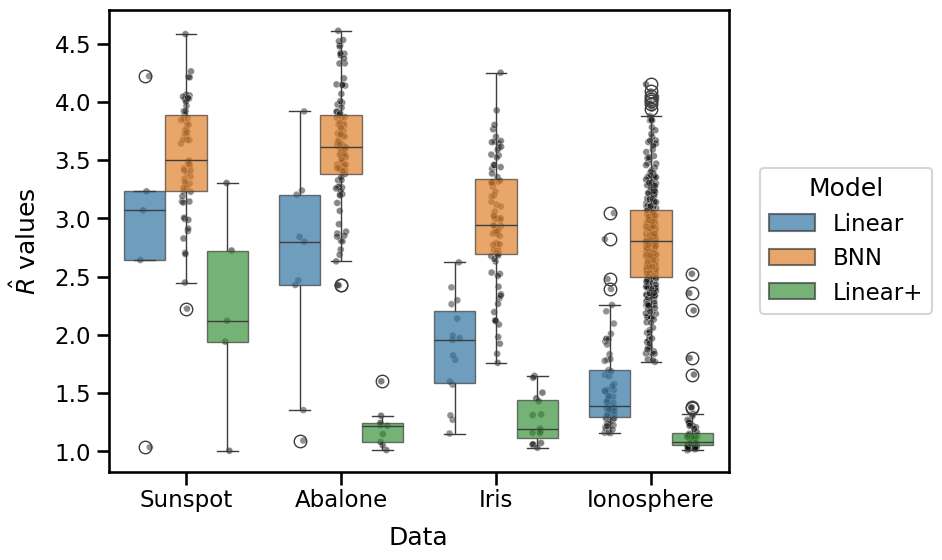

In [7]:
# plot a box and whisker plot with seaborn and the r_hat values
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.stripplot(
    x='data',y='rhat',hue='model',palette='dark:k',data=model_r_hat_az,ax=ax,
    edgecolor='white',linewidth=0.5, dodge=True, s=5, alpha=0.5, zorder=-99,
    legend=False
)

sns.boxplot(
    x='data',y='rhat',hue='model',data=model_r_hat_az,ax=ax,
    boxprops=dict(alpha=0.7) 
)
ax.set_ylabel('$\hat{R}$ values', labelpad=10)
ax.set_xlabel('Data', labelpad=10)
# y on log scale 
# ax.set_yscale('log')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
ax.get_legend().set_title('Model')      
    
if not 'linear_tp' in models:
    fig_dir = os.path.join(
        results_dir,
        'figures',
        'convergence'
    )
    os.makedirs(fig_dir, exist_ok=True)
    fig.savefig(os.path.join(fig_dir,'rhat_boxplot.pgf'),dpi=300,bbox_inches='tight')
plt.show()


In [8]:
# print this in a tabular format for the paper
results_r_hat = results_table.copy()
results_r_hat.set_index(['model','data'],inplace=True)
for this_model in models:
    # Oops I made this messy
    if this_model == 'linear':
        this_model_rhat = this_model.title()
    else:
        this_model_rhat = this_model.upper()
    # grab all the data for the table
    for this_data in data:
        results_r_hat.loc[(this_model,this_data),'mean r_hat'] = model_r_hat.loc[(model_r_hat.model==this_model_rhat) & (model_r_hat.data==this_data),'rhat'].mean()
        results_r_hat.loc[(this_model,this_data),'std r_hat'] = model_r_hat.loc[(model_r_hat.model==this_model_rhat) & (model_r_hat.data==this_data),'rhat'].std()

display(results_r_hat)

# return the latext to create this table with floats :.3f
print(results_r_hat.to_latex(index=True,float_format=lambda x: '{:.3f}'.format(x)))

train_mean  test_mean  train_std  test_std  \
model           data                                                     
linear          Sunspot       0.025217   0.021724   0.013317  0.011669   
                Abalone       0.085271   0.085565   0.007065  0.006940   
                Iris         90.392038  90.844089   2.832002  3.038877   
                Ionosphere   89.059739  85.316038   1.335095  2.389743   
bnn             Sunspot       0.026671   0.026011   0.004681  0.004635   
                Abalone       0.079517   0.079715   0.001996  0.001845   
                Iris         97.376952  98.116356   0.655043  1.656929   
                Ionosphere   99.631869  92.668491   0.356123  1.890454   
linear_thinning Sunspot       0.024030   0.020789   0.013757  0.011897   
                Abalone       0.084313   0.086390   0.007030  0.006864   
                Iris         90.169790  90.633156   3.119336  3.515944   
                Ionosphere   90.664201  87.492102   1.350353  2.126923   

                            mean r_hat   std r_hat  
model           data                                
linear          Sunspot      57.210395   46.542554  
                Abalone      11.360293    9.306002  
                Iris          4.364037    3.920030  
                Ionosphere    2.710224    3.512444  
bnn             Sunspot     189.135563  185.063225  
                Abalone     265.411816  228.855275  
                Iris         36.909863   27.696282  
                Ionosphere   24.889492   25.135972  
linear_thinning Sunspot            NaN         NaN  
                Abalone            NaN         NaN  
                Iris               NaN         NaN  
                Ionosphere         NaN         NaN

\begin{tabular}{llrrrrrr}
\toprule
 &  & train_mean & test_mean & train_std & test_std & mean r_hat & std r_hat \\
model & data &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{linear} & Sunspot & 0.025 & 0.022 & 0.013 & 0.012 & 57.210 & 46.543 \\
 & Abalone & 0.085 & 0.086 & 0.007 & 0.007 & 11.360 & 9.306 \\
 & Iris & 90.392 & 90.844 & 2.832 & 3.039 & 4.364 & 3.920 \\
 & Ionosphere & 89.060 & 85.316 & 1.335 & 2.390 & 2.710 & 3.512 \\
\cline{1-8}
\multirow[t]{4}{*}{bnn} & Sunspot & 0.027 & 0.026 & 0.005 & 0.005 & 189.136 & 185.063 \\
 & Abalone & 0.080 & 0.080 & 0.002 & 0.002 & 265.412 & 228.855 \\
 & Iris & 97.377 & 98.116 & 0.655 & 1.657 & 36.910 & 27.696 \\
 & Ionosphere & 99.632 & 92.668 & 0.356 & 1.890 & 24.889 & 25.136 \\
\cline{1-8}
\multirow[t]{4}{*}{linear_thinning} & Sunspot & 0.024 & 0.021 & 0.014 & 0.012 & NaN & NaN \\
 & Abalone & 0.084 & 0.086 & 0.007 & 0.007 & NaN & NaN \\
 & Iris & 90.170 & 90.633 & 3.119 & 3.516 & NaN & NaN \\
 & Ionosphere & 90.664 & 87.492 & 1.350 & 

## Plot posterior and trace
Plot the posterior distributions and trace plots for the MCMC samples.

In [21]:
# Now plot posterior distribution and trace plot for selected parameters
def plot_posterior(this_model, this_data, this_param, chain=0, save_dir=None):
    '''
    Plot the posterior as a histogram and then the traceplot
    '''
    plot_data = results[this_model][this_data][this_param].sel(chain=chain)
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # plot the posterior distribution
    sns.histplot(plot_data.values, ax=ax, bins=20)
    ax.set_xlabel(this_param, labelpad=10)
    ax.set_ylabel('Frequency', labelpad=10)
    ax.set_title('Posterior distribution', pad=10)
    fig.tight_layout()
    
    # plot the trace plot
    fig1, ax1 = plt.subplots(1,1,figsize=(6,4))
    sns.lineplot(x=plot_data.coords['samples'].values,y=plot_data.values,ax=ax1)
    ax1.set_xlabel('Samples', labelpad=10)
    ax1.set_ylabel(this_param, labelpad=10)
    ax1.set_title('Trace plot', pad=10)

    fig1.tight_layout()
    
    if not save_dir is None:
        fig.savefig(os.path.join(save_dir,'{}_{}_{}_posterior.png'.format(this_model,this_data,this_param)))
        fig1.savefig(os.path.join(save_dir,'{}_{}_{}_trace.png'.format(this_model,this_data,this_param)))


# Now use interact to plot for given model, data, param
warnings.simplefilter(action='ignore', category=FutureWarning)
param_names = [_ for _ in results[this_model][this_data].to_array().coords['variable'].values if not 'train' in _ and not 'test' in _]
interact(
    plot_posterior, 
    this_model=widgets.Dropdown(options=models, value=models[0]),
    this_data=widgets.Dropdown(options=data, value=data[0]),
    this_param=widgets.SelectionSlider(options=param_names, value=param_names[0]),
    chain=widgets.IntSlider(min=0,max=results[models[0]][data[0]].coords['chain'].shape[0]-1,step=1,value=0),
    save_dir=fixed(None)
)
None

interactive(children=(Dropdown(description='this_model', options=('linear', 'bnn', 'linear_thinning'), value='…